___
<font color='red'> <p style="font-weight: bold;">Master's Degree in Banking and Financial Regulation</p></font>

<font color='red'> University of Navarra</font>
___

<h2>GOAL</h2>
Develop a model to predict the Probability of Default (PD) of start-up companies with a supervised non-linear model. This kind of models allow risk managers and investors to make a statistically rational investment by only lending money to the start-ups most likely to succeed in the market by fulfilling all their debt obligations.

<h2>The exercise</h2>

- You are provided with historical dataset (historical_data.csv) containing start-up companies and their descriptive features. The database contains a column TARGET wich has the value 1 if the company has defaulted and 0 otherwise. The description of the columns is provided in the file 'Dataset Description.txt'

- This notebook contains a simplistic code to create a PD non-linear model, namely it builds a toy 'model' which is non-optimized. You must improve the current code.

<h2>Minimum standards required to pass the exercise</h2>

- Provide a detailed description of the 10 most relevant variables at business level. Please, provide as well a proper substantiation (either from business intuition or using statistical tools) about the motivation of choosing those 10 variables. Discuss their business meaning.


- Improve the current non-linear dummy model performance metric (AUC) on the Test dataset without introducing additional biases. You can do so by (the following options are not mandatory, they are just provided as a guideline) adding more variables to the model, and/or adding feature engineering methods, and/or optimizing the current algorithm hyperparameters, and/or using other Machine Learning algorithms. (Please keep in mind that when using a non-linear model, the introduction of Weight of Evidences is not necessary)


- Please provide explainability for the model and discuss whether the results have business "sense" or not. You can do so by (the following options are not mandatory, they are just provided as a guideline) using shapley values or methods embeded in the algorithm you decide to use.


- The delivery must be done with 2 files: A .ipynb and the same .ipynb file converted to .html (in your jupyter notebook: File -> Downloas as -> HTML (.html)). To provide explanations, use 'markdown' cells (like this one) as much as you need. The provided .pynb file must be functional, i.e. must be able to run in one go without errors.

# 1. Business Understanding

In this project, we aim to develop a `Probability of Default (PD)` model for start-up companies using a non-linear supervised approach. Banks, risk managers, and investors can use such a model to decide whether or not to lend money to a given start-up by estimating the likelihood that it will default on its obligations.

***Key objectives:***

- Identify the top features that drive a start-up’s ability to meet debt obligations.
- Build a robust, non-linear predictive model that achieves a higher AUC on the test set than the simplistic baseline model.
- Ensure the model has business interpretability.

# 2. Data Understanding


#### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#model libraries 
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import roc_auc_score, roc_curve
#To install sklearn, type in a terminal (anaconda prompt) the following line: conda install -c anaconda scikit-learn
import shap
#To install shap, type in a terminal (anaconda prompt) the following line: conda install -c conda-forge shap

g:\Uni Students\University of Navarra\univenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2.2 Description of column names

In [7]:
# Read the .txt file
with open('Dataset Description.txt', 'r') as file:
    content = file.read()

# Display in markdown with triple backticks
print(f"```\n{content}\n```")


```
Attribute Information:

X1	net profit / total assets 
X2	total liabilities / total assets 
X3	working capital / total assets 
X4	current assets / short-term liabilities 
X5	[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 
X6	retained earnings / total assets 
X7	EBIT / total assets 
X8	book value of equity / total liabilities 
X9	sales / total assets 
X10	equity / total assets 
X11	(gross profit + extraordinary items + financial expenses) / total assets 
X12	gross profit / short-term liabilities 
X13	(gross profit + depreciation) / sales 
X14	(gross profit + interest) / total assets 
X15	(total liabilities * 365) / (gross profit + depreciation) 
X16	(gross profit + depreciation) / total liabilities 
X17	total assets / total liabilities 
X18	gross profit / total assets 
X19	gross profit / sales 
X20	(inventory * 365) / sales 
X21	sales (n) / sales (n-1) 
X22	profit on operating activities / total assets 
X23	net prof

#### 2.3 Perform initial data exploration

In [2]:
df = pd.read_csv("historical_data.csv")
df.head()
# Number of rows & columns
print("Shape of DataFrame:", df.shape)

# Columns and their data types
df.info()

# Basic descriptive statistics for numeric columns
df.describe()


Shape of DataFrame: (4137, 66)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4137 entries, 0 to 4136
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      4137 non-null   object 
 1   X1      4134 non-null   float64
 2   X2      4134 non-null   float64
 3   X3      4134 non-null   float64
 4   X4      4121 non-null   float64
 5   X5      4129 non-null   float64
 6   X6      4134 non-null   float64
 7   X7      4134 non-null   float64
 8   X8      4124 non-null   float64
 9   X9      4136 non-null   float64
 10  X10     4134 non-null   float64
 11  X11     4134 non-null   float64
 12  X12     4121 non-null   float64
 13  X13     4137 non-null   float64
 14  X14     4134 non-null   float64
 15  X15     4131 non-null   float64
 16  X16     4124 non-null   float64
 17  X17     4124 non-null   float64
 18  X18     4134 non-null   float64
 19  X19     4137 non-null   float64
 20  X20     4137 non-null   float64
 21  X21   

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,TARGET
count,4134.000000,4134.000000,4134.000000,4121.000000,4.129000e+03,4134.000000,4134.000000,4124.000000,4136.000000,4134.000000,...,4137.000000,4134.000000,4137.000000,4134.000000,3.949000e+03,4127.000000,4137.000000,4121.000000,4057.000000,4137.000000
mean,-0.075833,0.545945,0.187800,5.418010,3.662161e+01,-0.110262,-0.062877,6.575037,1.584937,0.499839,...,0.051634,0.001927,0.968463,0.333420,1.280032e+03,10.658831,288.384862,9.573256,77.038430,0.069374
std,7.238919,1.463054,1.374335,108.643105,2.571938e+04,8.226181,7.239558,121.589082,1.368766,4.416764,...,0.808395,7.803169,1.004603,6.498465,7.668293e+04,37.886122,7422.010562,122.266953,2560.628674,0.254120
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-46.788000,-469.050000,-0.032029,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000
25%,0.003973,0.253823,0.045326,1.101300,-4.329000e+01,0.000000,0.006287,0.482190,1.015275,0.319095,...,0.010497,0.015565,0.876850,0.000000,5.251200e+00,4.289650,44.658000,3.080100,2.143200,0.000000
50%,0.046747,0.449170,0.219250,1.651700,4.921900e-01,0.000000,0.056609,1.148900,1.139300,0.522770,...,0.052906,0.108960,0.951180,0.005293,9.046300e+00,6.225400,73.038000,4.982600,4.077200,0.000000
75%,0.116157,0.661658,0.421338,2.939500,4.755300e+01,0.114365,0.135802,2.777100,1.813950,0.721183,...,0.124210,0.244877,0.990490,0.210395,1.728000e+01,9.362900,118.060000,8.113500,9.209200,0.000000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,451380.000000,7641.300000,158180.000000,1.000000


#### 2.4 Checking for Missing Values

In [3]:
# Calculate total NaN counts for each column
null_counts = df.isnull().sum()

# Calculate percentage of missing values for each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Print them separately
print("==== Null Counts ====")
print(null_counts)
print("\n==== Null Percentages ====")
print(null_percentages)

# (Optional) Combine both counts and percentages into a single DataFrame
missing_info = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages
})

print("\n==== Missing Value Summary ====")
print(missing_info)



==== Null Counts ====
ID         0
X1         3
X2         3
X3         3
X4        16
          ..
X61       10
X62        0
X63       16
X64       80
TARGET     0
Length: 66, dtype: int64

==== Null Percentages ====
ID        0.000000
X1        0.072516
X2        0.072516
X3        0.072516
X4        0.386754
            ...   
X61       0.241721
X62       0.000000
X63       0.386754
X64       1.933768
TARGET    0.000000
Length: 66, dtype: float64

==== Missing Value Summary ====
        Null Count  Null Percentage
ID               0         0.000000
X1               3         0.072516
X2               3         0.072516
X3               3         0.072516
X4              16         0.386754
...            ...              ...
X61             10         0.241721
X62              0         0.000000
X63             16         0.386754
X64             80         1.933768
TARGET           0         0.000000

[66 rows x 2 columns]


> **Key Insights**
> - `X64`column which is the `sales / fixed assets` stands out with approximately *1.93%* missing values (80 nulls). It is the highest among the features, suggesting it may need a specific imputation strategy or further investigation if the feature is critical for modeling.
> - Given the low percentages, standard imputation methods (like filling with mean/median) are likely sufficient for most columns.

#### 2.5 Target Variable Distribution

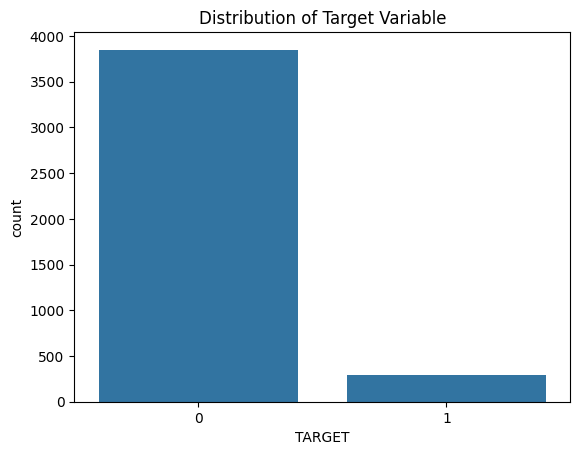

TARGET
0    93.062606
1     6.937394
Name: proportion, dtype: float64

In [4]:
import seaborn as sns

sns.countplot(x='TARGET', data=df)
plt.title('Distribution of Target Variable')
plt.show()

df['TARGET'].value_counts(normalize=True) * 100


> **Key Insights**
> - Around 93% of records are non-default `(TARGET=0)`, while only about 7% are default `(TARGET=1)`.
>>- This is a classic imbalanced classification scenario, which may lead many standard models to focus on predicting the majority class.
> - In credit default or fraud detection contexts, a low proportion of positives `(defaults/frauds)` is expected, reflecting real-world conditions.
>- These insights show us that there is need to plan for appropriate metics like `AUC`, `recall` or `precison` to better capture the minority class.

#### 2.6 Correlation Analysis

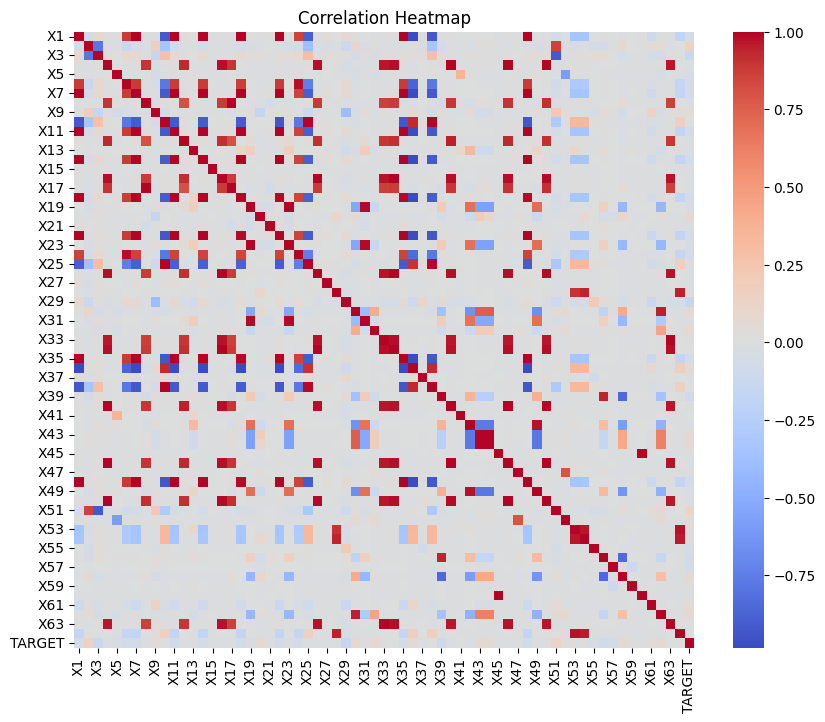

In [6]:
corr_matrix = df.drop(columns=['ID']).corr()  # drop ID to avoid messing up the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


#### 2.6 Feature Selection

Below is a list of 10 features that I've found valuable in predicting default.
1. X1 – `net profit / total assets`
- Healthy net profit relative to assets often signals lower default risk.
2. X2 – `total liabilities / total assets`
- Higher debt relative to assets can increase the likelihood of default if revenues/profits falter.
3. X7 – `EBIT / total assets`
- This focuses on operating profitability (EBIT), giving insight into the startup’s core business performance without the noise of interest/taxes.
4. X9 – `sales / total assets`
- This will show how effectively the company uses its assets to generate sales. Very low sales-to-asset levels can flag trouble.
5. X10 – `equity / total assets`
- Higher equity means stronger capitalization and, typically, lower risk of default.
6. X14 – `(gross profit + interest) / total assets`
- This combines gross profit with interest to gauge the company’s ability to handle financing costs relative to its asset base.
7. X17 – `total assets / total liabilities`
- If a firm’s liabilities approach or exceed its assets, default risk rises significantly.
8. X20 – `(inventory * 365) / sales`
A high ratio (meaning slow turnover) can signal potential cash flow problems.
9. X44 – `net profit / inventory`
This will show another lens on how effectively a firm’s profit outpaces its inventory investment. If net profit is small relative to huge inventory, that’s a red flag.
10. X60 – `sales / receivables`
This indicates how quickly the startup turns receivables into sales (and presumably cash). Slow receivables turnover can starve a company of liquidity.

## Data preprocessing

In [5]:
#filling NA's with the mean of the column:
df = df.fillna(df.mean())

TypeError: Could not convert ['A1A3A4A6A7A8A9A11A12A14A17A18A20A21A22A23A24A25A26A27A28A29A33A36A38A41A42A44A47A48A49A51A52A53A54A55A56A57A58A59A60A61A62A63A64A65A68A69A70A71A72A74A75A76A77A78A79A80A81A82A83A84A85A86A87A89A90A91A92A93A94A95A98A100A101A102A103A104A106A107A108A109A110A111A112A113A115A116A117A119A120A121A122A123A124A127A128A129A130A132A133A134A137A140A142A146A147A148A150A151A152A154A156A157A161A162A164A165A166A167A168A169A170A172A173A175A176A177A178A179A180A181A182A183A184A185A186A187A188A191A192A194A195A197A198A199A200A201A202A205A206A208A209A210A212A213A214A216A217A220A222A223A226A227A228A229A230A231A232A233A235A236A237A238A239A240A241A244A247A249A250A251A252A253A255A256A257A259A260A261A263A264A265A267A268A269A271A273A274A275A276A277A278A279A280A281A282A285A289A290A291A293A294A295A298A300A301A302A304A306A307A308A310A311A313A314A316A317A318A319A320A321A322A323A324A325A326A327A328A329A330A331A332A333A335A336A337A338A339A340A341A342A344A345A351A352A354A355A356A357A358A359A360A361A362A363A364A365A366A367A368A369A370A371A373A374A375A376A378A383A386A387A388A390A391A392A393A394A396A398A400A401A402A404A405A407A408A409A410A412A413A414A415A417A418A419A420A422A423A424A425A426A427A428A431A432A433A434A435A437A438A439A440A442A443A446A448A449A450A451A455A456A457A458A459A460A461A463A467A469A470A472A474A475A476A477A478A479A483A485A486A487A489A491A493A494A495A498A499A502A504A505A506A507A509A511A512A513A514A515A516A517A519A523A524A525A526A530A537A538A541A543A545A546A548A551A552A554A555A561A562A564A565A567A569A570A571A572A574A575A577A578A580A581A582A584A586A587A588A589A590A591A592A593A595A596A597A598A601A603A604A605A606A607A608A610A611A612A613A615A616A617A618A619A623A624A626A627A628A631A632A633A634A638A639A641A644A645A646A648A649A651A653A654A655A656A657A658A660A663A664A665A666A670A671A672A673A674A675A677A678A680A681A682A683A686A687A688A689A692A693A694A695A696A697A698A699A700A701A702A703A704A706A707A708A709A710A711A712A713A714A715A716A718A720A721A722A723A724A725A731A733A735A737A739A740A741A742A743A744A745A746A747A748A749A750A751A753A754A755A756A757A758A759A760A761A762A763A765A766A767A768A770A771A773A775A776A778A779A780A782A783A784A785A786A787A788A789A790A791A792A794A796A797A798A799A801A802A803A804A805A806A808A809A810A811A814A815A816A817A820A821A822A823A824A825A827A828A831A833A834A835A836A837A838A839A840A845A846A847A848A849A851A852A854A856A857A858A859A860A861A866A869A870A871A875A877A878A880A882A885A886A887A888A889A890A891A895A898A901A902A903A904A905A906A908A909A910A912A913A914A916A918A920A921A922A923A924A925A926A927A928A929A930A931A932A933A935A936A937A938A939A941A942A944A946A947A948A949A951A952A953A955A956A957A958A959A960A961A962A964A965A967A968A969A970A971A973A974A975A976A981A982A984A985A987A988A989A990A991A994A996A997A998A999A1000A1001A1005A1007A1008A1010A1011A1012A1016A1017A1018A1019A1020A1021A1022A1024A1025A1026A1027A1028A1029A1031A1033A1034A1037A1038A1039A1040A1041A1042A1045A1047A1048A1049A1050A1053A1054A1055A1056A1057A1058A1059A1060A1061A1062A1063A1064A1065A1069A1071A1072A1073A1074A1075A1077A1078A1079A1080A1081A1082A1083A1084A1087A1089A1090A1091A1093A1094A1095A1098A1100A1101A1102A1103A1104A1105A1106A1107A1108A1111A1112A1113A1114A1116A1118A1119A1121A1125A1126A1127A1128A1129A1130A1131A1132A1134A1135A1136A1137A1138A1139A1141A1144A1145A1147A1148A1149A1150A1151A1152A1153A1154A1155A1157A1158A1159A1160A1163A1165A1167A1168A1169A1170A1172A1174A1175A1176A1179A1180A1182A1183A1184A1185A1187A1188A1189A1191A1194A1195A1196A1199A1200A1201A1202A1203A1205A1206A1208A1209A1210A1211A1212A1213A1214A1215A1216A1218A1219A1220A1222A1223A1226A1227A1228A1229A1230A1231A1232A1233A1234A1236A1237A1238A1239A1240A1241A1242A1243A1244A1245A1250A1252A1253A1254A1255A1256A1257A1258A1259A1261A1264A1265A1266A1267A1269A1270A1272A1275A1277A1278A1279A1280A1281A1284A1287A1288A1290A1292A1293A1294A1296A1297A1298A1301A1302A1305A1306A1307A1308A1309A1310A1311A1312A1313A1314A1316A1317A1318A1319A1321A1322A1323A1324A1325A1326A1330A1332A1334A1335A1336A1338A1339A1340A1341A1342A1343A1345A1346A1347A1348A1349A1350A1351A1353A1354A1355A1356A1357A1360A1361A1362A1365A1366A1367A1369A1373A1374A1375A1376A1377A1379A1382A1383A1384A1385A1386A1388A1389A1390A1393A1395A1396A1397A1398A1400A1401A1402A1403A1404A1405A1406A1407A1408A1409A1410A1411A1413A1414A1416A1417A1418A1421A1424A1425A1426A1427A1429A1430A1433A1435A1436A1437A1438A1439A1440A1441A1442A1444A1445A1446A1447A1448A1450A1452A1455A1459A1460A1461A1463A1464A1467A1468A1469A1470A1471A1473A1474A1475A1477A1478A1479A1480A1481A1482A1484A1486A1487A1488A1489A1490A1491A1492A1493A1495A1497A1498A1499A1500A1502A1503A1504A1505A1507A1509A1510A1511A1513A1518A1519A1523A1528A1529A1531A1533A1535A1536A1538A1539A1540A1542A1544A1546A1547A1549A1550A1551A1553A1554A1555A1556A1558A1559A1561A1562A1563A1566A1567A1571A1573A1575A1576A1577A1578A1579A1580A1583A1584A1585A1586A1588A1589A1590A1592A1593A1595A1597A1599A1600A1601A1603A1604A1605A1606A1609A1610A1611A1612A1613A1614A1615A1617A1618A1619A1620A1622A1624A1627A1628A1629A1630A1631A1632A1634A1635A1636A1637A1638A1639A1640A1641A1642A1646A1647A1648A1649A1650A1651A1653A1654A1655A1656A1657A1659A1660A1661A1662A1664A1665A1666A1668A1672A1673A1674A1675A1677A1678A1679A1680A1682A1683A1684A1685A1686A1687A1690A1691A1692A1694A1695A1696A1698A1700A1701A1702A1704A1705A1708A1709A1710A1712A1714A1715A1717A1718A1720A1721A1722A1724A1725A1726A1728A1729A1730A1731A1732A1733A1734A1735A1736A1738A1739A1740A1741A1744A1746A1748A1749A1752A1753A1754A1757A1758A1759A1760A1761A1762A1763A1765A1766A1769A1770A1771A1773A1774A1775A1776A1777A1778A1780A1781A1782A1783A1785A1786A1788A1789A1792A1793A1794A1795A1796A1797A1798A1799A1800A1801A1802A1803A1804A1806A1807A1808A1809A1810A1811A1812A1813A1815A1819A1821A1822A1823A1824A1826A1828A1833A1835A1836A1837A1839A1840A1842A1843A1845A1846A1847A1848A1850A1851A1852A1853A1854A1855A1857A1858A1859A1861A1863A1864A1865A1867A1869A1870A1872A1873A1874A1875A1877A1878A1879A1880A1881A1882A1883A1884A1885A1886A1887A1889A1891A1894A1895A1896A1897A1898A1899A1900A1902A1903A1904A1905A1906A1908A1909A1910A1911A1912A1913A1914A1915A1916A1918A1919A1920A1921A1924A1925A1926A1928A1930A1931A1933A1936A1938A1939A1941A1943A1944A1945A1946A1948A1949A1951A1952A1953A1955A1956A1957A1960A1961A1963A1964A1965A1967A1968A1969A1971A1972A1973A1974A1976A1977A1979A1981A1982A1984A1988A1989A1992A1993A1994A1995A1998A1999A2000A2001A2002A2003A2004A2005A2006A2008A2009A2011A2014A2016A2017A2019A2020A2021A2022A2023A2024A2025A2026A2029A2032A2033A2035A2036A2038A2040A2041A2042A2043A2046A2047A2048A2050A2051A2052A2053A2054A2055A2056A2057A2058A2060A2062A2063A2064A2065A2069A2070A2073A2074A2075A2077A2078A2080A2081A2083A2084A2085A2086A2087A2093A2094A2095A2096A2097A2098A2099A2100A2102A2103A2106A2108A2110A2111A2113A2114A2115A2116A2117A2118A2120A2121A2122A2123A2124A2126A2127A2128A2129A2130A2131A2135A2136A2137A2139A2140A2143A2144A2145A2146A2147A2148A2149A2150A2151A2152A2154A2156A2157A2158A2159A2160A2161A2162A2164A2167A2168A2169A2170A2171A2172A2174A2175A2177A2181A2182A2183A2184A2185A2186A2187A2188A2192A2193A2194A2196A2198A2199A2200A2203A2204A2206A2207A2209A2210A2211A2213A2214A2216A2217A2219A2220A2221A2222A2223A2226A2227A2228A2230A2232A2234A2237A2238A2239A2246A2247A2249A2250A2252A2253A2254A2255A2257A2258A2259A2262A2264A2265A2267A2269A2270A2272A2274A2275A2276A2277A2278A2281A2282A2283A2284A2285A2286A2287A2288A2289A2290A2291A2292A2293A2296A2297A2298A2299A2300A2303A2305A2306A2307A2308A2309A2310A2311A2313A2314A2317A2318A2319A2320A2321A2322A2323A2325A2327A2328A2330A2331A2332A2333A2334A2336A2337A2339A2342A2343A2344A2345A2348A2349A2350A2352A2353A2354A2355A2357A2359A2360A2361A2362A2363A2364A2365A2366A2367A2368A2371A2372A2374A2375A2376A2377A2379A2381A2384A2385A2386A2387A2388A2390A2391A2392A2393A2394A2395A2396A2397A2398A2399A2404A2406A2407A2408A2409A2410A2411A2412A2413A2414A2415A2416A2417A2418A2419A2420A2421A2423A2425A2427A2428A2429A2431A2432A2433A2435A2436A2437A2438A2439A2440A2441A2442A2443A2445A2446A2447A2449A2450A2452A2453A2454A2455A2459A2460A2462A2463A2464A2467A2468A2469A2470A2471A2472A2474A2475A2476A2477A2479A2480A2481A2483A2486A2487A2488A2489A2490A2491A2492A2493A2494A2495A2496A2497A2498A2499A2500A2503A2504A2505A2507A2508A2509A2510A2511A2512A2513A2515A2516A2517A2518A2520A2521A2523A2525A2528A2532A2533A2536A2537A2538A2539A2541A2542A2543A2545A2546A2547A2548A2549A2550A2553A2555A2556A2557A2558A2559A2560A2561A2562A2563A2565A2566A2568A2569A2570A2571A2573A2574A2577A2578A2582A2583A2584A2585A2586A2588A2590A2592A2594A2596A2597A2598A2599A2600A2604A2606A2607A2608A2610A2611A2612A2614A2615A2622A2623A2624A2628A2629A2631A2632A2633A2634A2635A2638A2639A2643A2644A2645A2646A2647A2648A2650A2651A2655A2657A2659A2660A2661A2662A2663A2664A2666A2667A2668A2669A2671A2672A2674A2675A2676A2677A2678A2680A2681A2682A2684A2685A2686A2688A2689A2691A2692A2693A2694A2695A2696A2697A2698A2699A2700A2702A2703A2704A2705A2706A2709A2711A2712A2713A2714A2716A2718A2720A2722A2723A2724A2726A2727A2728A2729A2730A2731A2733A2734A2735A2736A2737A2738A2740A2742A2743A2745A2746A2747A2749A2751A2752A2755A2757A2758A2760A2764A2765A2766A2767A2768A2769A2771A2773A2774A2775A2776A2777A2779A2780A2781A2782A2783A2784A2786A2787A2788A2789A2790A2792A2793A2795A2796A2797A2798A2799A2801A2802A2803A2804A2805A2806A2809A2812A2813A2814A2815A2816A2817A2820A2821A2822A2823A2824A2825A2826A2828A2834A2835A2836A2837A2838A2840A2845A2846A2851A2852A2853A2855A2856A2857A2861A2862A2863A2864A2865A2866A2867A2868A2870A2871A2872A2873A2875A2876A2880A2881A2882A2886A2887A2890A2894A2896A2897A2898A2899A2901A2902A2904A2905A2908A2909A2911A2912A2913A2915A2916A2917A2918A2919A2920A2923A2924A2925A2926A2927A2928A2929A2930A2931A2935A2936A2938A2942A2943A2945A2946A2948A2949A2951A2952A2953A2955A2957A2958A2959A2961A2964A2965A2966A2967A2968A2969A2971A2973A2974A2975A2976A2977A2978A2979A2981A2982A2983A2986A2988A2989A2990A2991A2992A2994A2995A2996A2997A2998A2999A3000A3003A3004A3005A3006A3007A3008A3011A3012A3013A3015A3016A3017A3018A3020A3021A3022A3023A3024A3025A3026A3027A3029A3032A3034A3035A3036A3037A3040A3042A3044A3045A3046A3047A3048A3050A3052A3053A3054A3055A3057A3058A3060A3061A3063A3064A3066A3069A3071A3072A3073A3076A3077A3078A3079A3085A3086A3088A3089A3090A3092A3095A3097A3098A3099A3100A3101A3102A3103A3104A3105A3106A3107A3108A3109A3110A3112A3114A3115A3116A3117A3123A3124A3126A3127A3128A3129A3130A3134A3135A3137A3138A3139A3140A3143A3144A3145A3147A3149A3150A3152A3153A3154A3157A3160A3161A3164A3166A3167A3169A3171A3173A3175A3178A3179A3180A3182A3184A3185A3186A3187A3188A3189A3190A3191A3192A3194A3195A3196A3197A3199A3200A3202A3203A3205A3206A3207A3209A3212A3214A3215A3216A3217A3218A3219A3220A3222A3223A3224A3225A3227A3228A3231A3232A3233A3234A3235A3237A3238A3239A3240A3245A3246A3247A3248A3249A3250A3251A3253A3254A3255A3257A3258A3259A3260A3262A3264A3265A3266A3269A3270A3271A3272A3273A3274A3275A3276A3278A3279A3280A3281A3282A3283A3284A3285A3286A3288A3290A3291A3292A3293A3294A3296A3299A3300A3301A3302A3303A3304A3307A3309A3310A3311A3312A3313A3314A3315A3317A3318A3320A3323A3324A3325A3326A3327A3328A3329A3330A3331A3332A3333A3334A3335A3336A3337A3338A3339A3340A3341A3342A3343A3344A3345A3346A3347A3348A3349A3350A3353A3355A3356A3357A3358A3359A3361A3362A3363A3364A3365A3367A3369A3370A3371A3372A3373A3376A3377A3378A3380A3381A3382A3383A3384A3385A3387A3388A3390A3391A3392A3393A3394A3396A3397A3398A3399A3400A3401A3402A3404A3405A3407A3408A3410A3414A3415A3416A3419A3420A3421A3422A3423A3424A3426A3427A3430A3431A3435A3436A3437A3438A3441A3442A3443A3445A3446A3447A3448A3449A3450A3451A3452A3453A3455A3456A3459A3460A3462A3463A3464A3466A3467A3468A3469A3470A3471A3473A3475A3476A3478A3479A3484A3485A3486A3487A3488A3489A3490A3491A3493A3495A3496A3497A3498A3500A3501A3502A3505A3506A3507A3508A3510A3511A3512A3514A3515A3516A3517A3520A3523A3524A3525A3526A3527A3528A3530A3531A3532A3533A3534A3535A3537A3538A3540A3541A3542A3543A3544A3547A3548A3549A3550A3555A3556A3557A3558A3560A3561A3562A3565A3567A3568A3570A3572A3574A3575A3576A3577A3578A3581A3584A3589A3590A3591A3592A3593A3594A3595A3596A3597A3598A3599A3600A3601A3602A3603A3605A3608A3609A3611A3612A3613A3614A3616A3618A3620A3622A3623A3624A3625A3626A3628A3630A3633A3634A3636A3637A3640A3641A3643A3645A3648A3649A3652A3653A3655A3658A3660A3662A3665A3666A3667A3668A3669A3671A3673A3675A3676A3677A3679A3680A3681A3682A3683A3684A3686A3687A3688A3690A3694A3695A3696A3699A3700A3703A3704A3705A3707A3708A3709A3712A3713A3714A3715A3716A3717A3718A3719A3721A3722A3723A3724A3726A3728A3730A3731A3732A3733A3734A3735A3737A3738A3742A3743A3744A3746A3747A3748A3749A3750A3751A3752A3753A3756A3757A3758A3759A3760A3762A3763A3766A3768A3770A3771A3772A3773A3774A3778A3779A3782A3783A3784A3785A3786A3787A3788A3792A3793A3794A3795A3796A3797A3798A3800A3801A3802A3803A3805A3806A3807A3808A3809A3810A3811A3812A3813A3814A3816A3817A3818A3819A3820A3821A3822A3823A3826A3827A3828A3829A3833A3835A3836A3837A3840A3842A3843A3845A3847A3848A3852A3854A3855A3856A3857A3858A3860A3861A3864A3865A3867A3868A3869A3870A3876A3877A3878A3879A3880A3881A3882A3883A3884A3887A3888A3890A3892A3894A3895A3897A3898A3899A3900A3902A3905A3906A3907A3908A3909A3911A3912A3913A3914A3915A3916A3917A3918A3919A3920A3921A3923A3924A3925A3926A3927A3929A3930A3934A3935A3937A3938A3939A3941A3943A3946A3947A3949A3950A3953A3954A3955A3956A3959A3960A3961A3963A3964A3966A3967A3968A3969A3970A3971A3972A3973A3974A3979A3980A3981A3982A3983A3984A3985A3986A3987A3988A3989A3991A3992A3995A3996A3997A3998A3999A4000A4001A4003A4004A4005A4006A4007A4008A4010A4011A4012A4018A4019A4020A4021A4023A4024A4025A4026A4027A4029A4032A4034A4035A4037A4038A4039A4040A4041A4043A4044A4045A4048A4049A4050A4051A4052A4057A4058A4060A4067A4068A4070A4071A4072A4073A4076A4077A4078A4079A4080A4081A4082A4088A4089A4090A4091A4093A4094A4095A4097A4098A4100A4104A4105A4106A4107A4108A4109A4110A4113A4115A4118A4119A4120A4123A4125A4126A4127A4129A4130A4131A4132A4135A4137A4138A4140A4142A4143A4144A4146A4147A4148A4149A4150A4151A4152A4153A4154A4156A4157A4158A4159A4160A4161A4162A4164A4165A4166A4168A4169A4172A4173A4174A4175A4176A4178A4180A4181A4183A4184A4185A4186A4187A4188A4189A4190A4192A4193A4199A4200A4202A4203A4207A4208A4209A4211A4212A4213A4214A4217A4218A4219A4222A4223A4224A4227A4228A4232A4233A4234A4235A4236A4237A4239A4240A4241A4242A4243A4244A4245A4247A4248A4249A4251A4252A4254A4256A4257A4259A4260A4261A4263A4264A4265A4268A4269A4272A4273A4274A4275A4276A4278A4280A4281A4283A4285A4286A4287A4290A4291A4293A4295A4296A4297A4298A4299A4300A4301A4304A4306A4307A4309A4310A4312A4314A4315A4316A4317A4318A4320A4322A4325A4327A4328A4331A4332A4333A4334A4336A4337A4338A4341A4342A4343A4344A4345A4348A4349A4351A4352A4354A4355A4357A4358A4359A4362A4363A4365A4366A4367A4368A4369A4370A4371A4373A4374A4375A4378A4379A4383A4384A4385A4386A4387A4388A4392A4393A4394A4395A4396A4397A4398A4399A4401A4402A4403A4404A4405A4406A4409A4410A4412A4413A4415A4416A4418A4419A4420A4421A4422A4424A4426A4427A4428A4429A4431A4432A4433A4434A4435A4436A4437A4438A4439A4442A4443A4444A4445A4447A4448A4449A4450A4451A4452A4453A4454A4455A4456A4459A4460A4461A4462A4463A4465A4466A4468A4469A4470A4471A4472A4474A4475A4477A4478A4479A4480A4482A4485A4486A4487A4488A4490A4491A4492A4494A4495A4497A4498A4501A4503A4504A4506A4507A4509A4513A4514A4515A4516A4517A4518A4519A4520A4523A4524A4525A4526A4527A4531A4532A4534A4536A4539A4540A4542A4543A4544A4546A4547A4548A4549A4550A4551A4552A4553A4554A4557A4558A4559A4561A4562A4563A4565A4566A4567A4568A4570A4571A4573A4576A4578A4580A4581A4582A4583A4584A4585A4587A4588A4589A4591A4592A4594A4595A4597A4598A4599A4601A4602A4604A4606A4610A4611A4612A4613A4614A4615A4619A4620A4621A4623A4624A4625A4627A4629A4631A4632A4634A4636A4637A4640A4642A4644A4645A4646A4648A4649A4651A4652A4653A4655A4656A4657A4658A4659A4660A4661A4662A4663A4664A4665A4666A4667A4668A4669A4670A4671A4673A4674A4675A4676A4677A4679A4681A4682A4683A4684A4685A4686A4687A4688A4690A4691A4692A4695A4696A4697A4698A4699A4700A4702A4703A4704A4705A4707A4708A4709A4710A4711A4713A4714A4715A4716A4718A4719A4720A4721A4722A4723A4724A4726A4727A4728A4729A4730A4732A4734A4735A4736A4737A4739A4741A4744A4746A4747A4748A4749A4750A4752A4753A4754A4755A4756A4757A4759A4760A4761A4762A4763A4764A4765A4766A4767A4768A4769A4770A4771A4772A4773A4775A4776A4777A4778A4779A4780A4783A4785A4786A4788A4789A4791A4792A4795A4796A4798A4800A4801A4804A4805A4807A4809A4810A4811A4812A4813A4814A4815A4816A4817A4818A4820A4822A4823A4825A4826A4830A4831A4832A4834A4835A4837A4838A4839A4841A4842A4844A4845A4846A4847A4848A4850A4851A4852A4853A4856A4857A4859A4860A4861A4863A4864A4865A4867A4868A4871A4872A4873A4877A4878A4879A4880A4881A4882A4883A4884A4886A4887A4888A4890A4892A4893A4895A4896A4897A4898A4903A4904A4905A4906A4907A4909A4910A4913A4914A4917A4919A4921A4923A4924A4926A4928A4930A4931A4932A4933A4934A4937A4938A4939A4940A4941A4943A4944A4949A4950A4951A4952A4954A4955A4956A4958A4959A4960A4962A4963A4964A4965A4966A4967A4968A4969A4970A4971A4973A4977A4978A4979A4980A4982A4983A4984A4985A4986A4987A4988A4989A4992A4993A4995A4996A4997A4998A4999A5000A5001A5004A5006A5007A5008A5010A5011A5012A5013A5018A5019A5021A5022A5023A5024A5026A5027A5029A5030A5031A5035A5037A5038A5039A5041A5042A5043A5044A5045A5046A5047A5051A5052A5053A5056A5058A5059A5062A5064A5065A5066A5068A5069A5071A5072A5073A5074A5075A5076A5077A5078A5079A5080A5081A5082A5083A5084A5085A5086A5087A5088A5089A5090A5091A5094A5096A5100A5101A5103A5104A5105A5106A5108A5109A5111A5114A5116A5117A5118A5119A5120A5121A5122A5123A5124A5125A5126A5127A5129A5130A5131A5134A5135A5137A5138A5140A5142A5143A5144A5145A5146A5147A5148A5149A5150A5155A5158A5160A5161A5162A5163A5164A5165A5166A5167A5168A5169A5171A5172A5173A5174A5175A5176A5177A5179A5182A5185A5186A5187A5188A5190A5192A5193A5194A5195A5196A5198A5199A5200A5201A5204A5205A5208A5209A5210A5211A5214A5216A5217A5218A5219A5220A5221A5222A5224A5225A5226A5227A5228A5229A5230A5232A5233A5235A5236A5238A5239A5240A5241A5242A5243A5244A5245A5246A5247A5248A5250A5252A5253A5254A5255A5257A5258A5260A5261A5267A5269A5270A5271A5272A5273A5274A5276A5277A5278A5279A5280A5284A5285A5286A5287A5290A5291A5294A5295A5296A5297A5298A5299A5301A5302A5303A5307A5308A5309A5310A5312A5313A5314A5315A5317A5318A5319A5322A5325A5326A5327A5328A5329A5331A5332A5337A5338A5340A5344A5346A5347A5348A5349A5350A5352A5353A5356A5357A5359A5360A5364A5365A5369A5370A5371A5373A5374A5375A5376A5377A5379A5381A5383A5384A5385A5386A5387A5388A5390A5391A5392A5394A5395A5396A5397A5399A5400A5401A5402A5403A5404A5406A5407A5409A5411A5412A5413A5414A5416A5417A5420A5421A5422A5424A5426A5428A5429A5430A5431A5433A5434A5435A5436A5437A5439A5441A5442A5443A5445A5446A5447A5448A5449A5450A5451A5455A5456A5457A5459A5460A5461A5462A5463A5464A5465A5467A5468A5469A5470A5471A5472A5473A5476A5478A5479A5480A5481A5482A5483A5484A5485A5488A5490A5491A5492A5493A5494A5495A5497A5498A5499A5500A5501A5502A5503A5504A5505A5506A5508A5510A5511A5513A5515A5517A5518A5519A5520A5521A5523A5524A5526A5527A5528A5529A5530A5532A5536A5537A5540A5541A5542A5543A5544A5545A5546A5547A5548A5549A5550A5551A5552A5557A5558A5559A5560A5561A5563A5564A5565A5566A5567A5569A5571A5572A5573A5574A5575A5576A5577A5579A5580A5581A5582A5584A5585A5586A5587A5588A5589A5591A5592A5593A5594A5595A5596A5599A5600A5601A5602A5604A5605A5606A5607A5608A5610A5612A5613A5614A5615A5616A5617A5618A5619A5620A5622A5625A5628A5630A5631A5632A5633A5634A5635A5637A5639A5640A5641A5644A5646A5647A5648A5651A5654A5655A5657A5659A5660A5661A5662A5664A5666A5668A5669A5670A5672A5673A5674A5675A5676A5678A5681A5682A5684A5685A5686A5687A5689A5691A5692A5694A5695A5696A5698A5699A5701A5702A5703A5704A5705A5707A5709A5711A5712A5713A5716A5719A5720A5721A5722A5724A5726A5727A5728A5729A5730A5732A5733A5734A5735A5736A5737A5739A5740A5741A5742A5743A5744A5745A5746A5747A5749A5750A5752A5753A5756A5757A5759A5762A5763A5764A5765A5766A5767A5768A5769A5770A5771A5773A5774A5775A5776A5777A5778A5780A5781A5783A5784A5785A5786A5787A5789A5790A5793A5794A5796A5797A5798A5799A5803A5804A5805A5806A5807A5808A5809A5810A5812A5813A5814A5815A5816A5817A5818A5819A5820A5822A5823A5824A5825A5826A5828A5829A5830A5831A5833A5834A5835A5838A5839A5840A5841A5842A5844A5845A5848A5849A5851A5852A5853A5855A5857A5858A5859A5860A5862A5863A5865A5866A5867A5868A5869A5871A5872A5873A5874A5875A5876A5877A5879A5880A5881A5882A5883A5884A5885A5886A5887A5888A5889A5892A5893A5894A5895A5896A5898A5899A5900A5901A5903A5904A5905A5907A5908A5910'] to numeric

In [ ]:
#Preparing the data to feed the algorithm
#The dummy model only uses the first 10 features
features_names=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
print(features_names)

#Name of the target variable
target_name='TARGET'

# Converting the dataframe into numpy arrays
X = np.array(df[features_names])
y = np.array(df[target_name])

#Creating a train test subsets for the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
#Now the data is prepared to feed the algorithm

## Model

In [6]:
#Model definition
the_model = RandomForestClassifier(n_estimators=20, max_depth=2 ,criterion='gini') 

In [ ]:
#Model Training
the_model.fit(X_train, y_train)

In [ ]:
#prediction an train Metrics
y_train_pred = the_model.predict_proba(X_train)[:, 1]
print(y_train_pred)
AUC_train    = roc_auc_score(y_train, y_train_pred)
print("AUC:", AUC_train) 

In [ ]:
#prediction an train Metrics
y_test_pred = the_model.predict_proba(X_test)[:, 1]
print(y_train_pred)
AUC_test    = roc_auc_score(y_test, y_test_pred)
print("AUC:", AUC_test)

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()